In [35]:
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
df1 = pd.read_csv('../data/timetable.csv')
df2 = pd.read_csv('../data/timetable_simple.csv')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

In [37]:
def compute_metrics(df):
    metrics = {}
    tmp = df.groupby(['Teacher', 'Day', 'Slot']).size().reset_index(name='count')
    teacher_day = df.groupby(['Teacher', 'Day']).size()
    metrics['avg_lessons_per_teacher_per_day'] = teacher_day.mean()

    metrics['avg_lessons_by_weekday'] = avg.sort_index()

    group_day = df.groupby(['Group', 'Day']).size()
    metrics['avg_lessons_per_group_per_day'] = group_day.mean()


    dup = df.groupby(['Group', 'Week', 'Day', 'Slot']).size()
    metrics['student_conflicts'] = int((dup[dup > 1] - 1).sum())

    room_week = df.groupby(['Room', 'Week']).size()
    metrics['avg_lessons_per_room_per_week'] = room_week.mean()

    return metrics


In [38]:
met1 = compute_metrics(df1)
met2 = compute_metrics(df2)
# Середня кількість пар для викладача на день
plt.figure(figsize=(6, 4))
plt.bar(['Schedule 1', 'Schedule 2'],
        [met1['avg_lessons_per_teacher_per_day'], met2['avg_lessons_per_teacher_per_day']])
plt.title('Avg Lessons per Teacher per Day')
plt.ylabel('Пари')

NameError: name 'avg' is not defined

Text(0, 0.5, 'Пари')

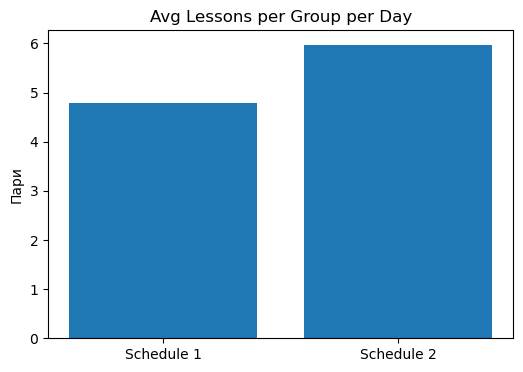

In [28]:
met1 = compute_metrics(df1)
met2 = compute_metrics(df2)
# Середня кількість пар для групи на день
plt.figure(figsize=(6, 4))
plt.bar(['Schedule 1', 'Schedule 2'],
        [met1['avg_lessons_per_group_per_day'], met2['avg_lessons_per_group_per_day']])
plt.title('Avg Lessons per Group per Day')
plt.ylabel('Пари')

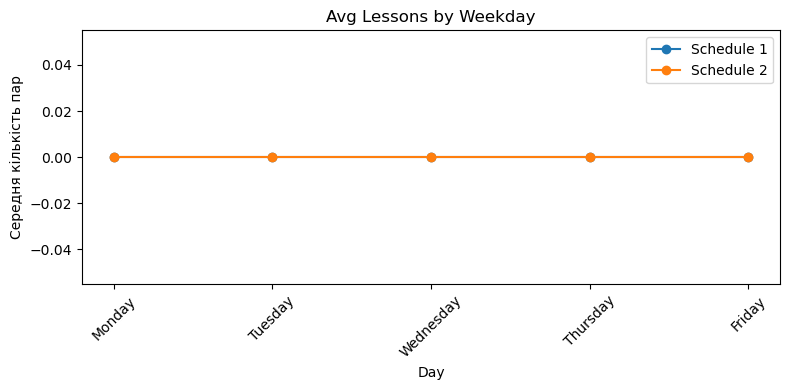

Text(0, 0.5, 'Кількість накладок')

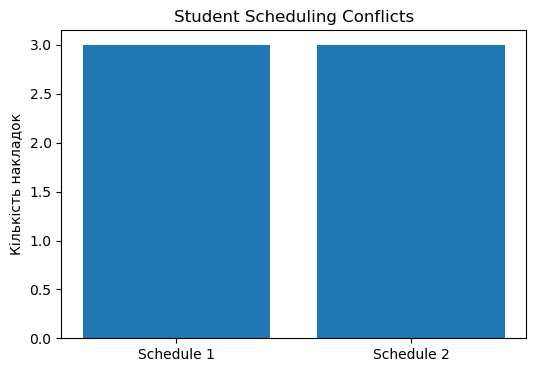

In [30]:
met1 = compute_metrics(df1)
met2 = compute_metrics(df2)
#  Кількість накладок для студентів
plt.figure(figsize=(6, 4))
plt.bar(['Schedule 1', 'Schedule 2'], [met1['student_conflicts'], met2['student_conflicts']])
plt.title('Student Scheduling Conflicts')
plt.ylabel('Кількість накладок')

Text(0, 0.5, 'Пари')

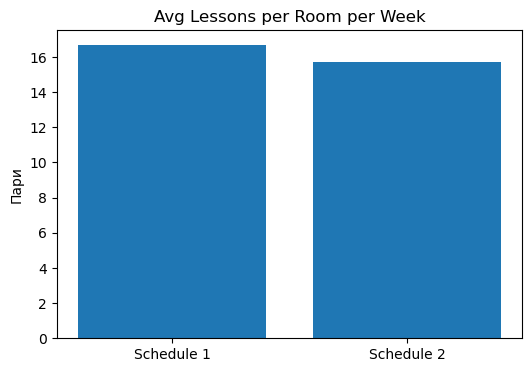

In [31]:
met1 = compute_metrics(df1)
met2 = compute_metrics(df2)
# Завантаження аудиторій
plt.figure(figsize=(6, 4))
plt.bar(['Schedule 1', 'Schedule 2'],
        [met1['avg_lessons_per_room_per_week'], met2['avg_lessons_per_room_per_week']])
plt.title('Avg Lessons per Room per Week')
plt.ylabel('Пари')

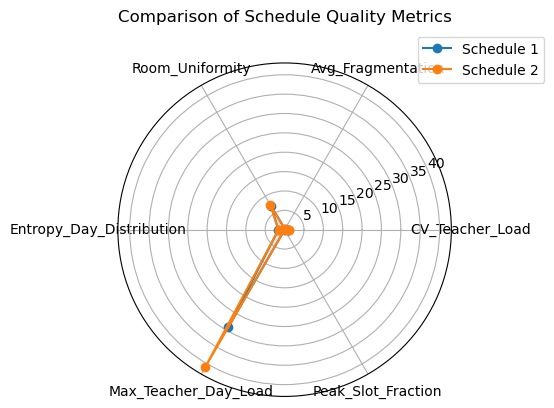

In [40]:
import numpy as np
def compute_quality_metrics(df):
    metrics = {}

    # 1. Рівномірність навантаження викладачів
    teachers = df['Teacher'].unique()
    cvs = []
    days_all = df['Day'].unique()
    for t in teachers:
        counts = df[df['Teacher'] == t].groupby('Day').size().reindex(days_all, fill_value=0)
        mu, sigma = counts.mean(), counts.std(ddof=0)
        cvs.append(sigma/mu if mu > 0 else 0)
    metrics['CV_Teacher_Load'] = np.mean(cvs)

    # 2. Фрагментація дня для студентів (середні "прогалини" між першою та останньою парою)
    frags = []
    for _, grp in df.groupby(['Group','Week','Day']):
        slots = grp['Slot']
        if len(slots) > 0:
            frag = (slots.max() - slots.min() + 1) - len(slots)
            frags.append(frag)
    metrics['Avg_Fragmentation'] = np.mean(frags)

    # 3. Рівномірність використання аудиторій (σ занять на кімнату в тиждень)
    room_week = df.groupby(['Room','Week']).size().unstack(fill_value=0)
    metrics['Room_Uniformity'] = room_week.std(axis=1, ddof=0).mean()

    # 4. Ентропія розподілу пар по днях тижня
    lessons_by_day = df.groupby('Day').size()
    p = lessons_by_day / lessons_by_day.sum()
    metrics['Entropy_Day_Distribution'] = -(p * np.log(p)).sum()

    # 5. Максимальне навантаження викладача в день
    metrics['Max_Teacher_Day_Load'] = df.groupby(['Teacher','Day']).size().max()

    # 6. Частка "пікових" слотів (≥80% кімнат зайнято)
    total_rooms = df['Room'].nunique()
    slot_occ = df.groupby(['Week','Day','Slot'])['Room'].nunique()
    peak_slots = (slot_occ >= 0.8 * total_rooms).sum()
    metrics['Peak_Slot_Fraction'] = peak_slots / slot_occ.size

    return metrics

met1 = compute_quality_metrics(df1)
met2 = compute_quality_metrics(df2)

labels = list(met1.keys())
vals1 = list(met1.values())
vals2 = list(met2.values())

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]
vals1 += vals1[:1]
vals2 += vals2[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, vals1, marker='o', label='Schedule 1')
ax.fill(angles, vals1, alpha=0.1)
ax.plot(angles, vals2, marker='o', label='Schedule 2')
ax.fill(angles, vals2, alpha=0.1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, wrap=True)
ax.set_title('Comparison of Schedule Quality Metrics', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()